<center><h1>Parkinson disease diagnostic using time series data</h1></center>
<center><h2>Classification using gradient boosting</h2></center>

# Importation of librairies

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

# Import the data

In [2]:
df = pd.read_csv('preprocessed-data\preprocessed_data.csv')

df.head()

,ID,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,GaPt03,Ga,PD,3,female,82,1.45,50.000000,3.0,20.0,...,0.543326,0.250426,0.124893,0.7299,0.0100,16.856355,22.986800,36.693073,-429.032245,0.935088
1,GaPt04,Ga,PD,4,male,68,1.71,72.524691,2.5,25.0,...,-0.859187,0.182767,0.161860,-0.7200,-1.8899,14.242531,-18.838775,-69.058996,96.502798,0.865798
2,GaPt05,Ga,PD,5,female,82,1.53,51.000000,2.5,24.0,...,-0.609242,0.108519,0.044731,-0.5400,-0.8200,10.185169,-7.342067,-61.899132,41.773520,0.606564
3,GaPt06,Ga,PD,6,male,72,1.70,82.000000,2.0,16.0,...,0.413048,0.051538,0.019363,0.4600,0.3000,4.494682,4.687939,36.047953,-42.744401,0.154679
4,GaPt07,Ga,PD,7,female,53,1.67,54.000000,3.0,44.0,...,0.535093,0.535390,0.079130,0.7000,0.1800,36.544871,14.788033,38.060962,-135.812348,0.592562


# Get the features and labels and encode them

In [3]:
# Separate the features and the label
X = df.drop(['ID', 'Study', 'Subjnum', 'Group'], axis=1)
y = df['Group']

# Convert the categorical label to numbers
y = y.astype('category')
y = y.cat.codes

# Convert "Gender" in X to numbers
X['Gender'] = X['Gender'].replace({'female': 0, 'male': 1})

# normalize the data
scaler = MinMaxScaler()
X[X.columns[:]] = scaler.fit_transform(X[X.columns[:]])

X.head()

,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10,...,mean_swing_time_left,std_stride_left,std_swing_left,max_swing_left,min_swing_left,cv_stride_left,cv_swing_left,mean_swing_stride_ratio_left,log_left,mean_double_stance_time
0,0.0,0.92,0.000000,0.051724,1.000000,0.285714,0.227273,1.000000,0.646212,0.421779,...,0.987532,0.420505,0.450450,0.749988,0.867420,0.319581,0.971977,0.988728,0.060274,0.113510
1,1.0,0.64,0.001417,0.440081,0.833333,0.357143,0.181818,0.158419,0.238579,0.452454,...,0.186538,0.294175,0.596647,0.078707,0.342542,0.262351,0.388799,0.905067,0.632267,0.104723
2,0.0,0.92,0.000436,0.068966,0.833333,0.342857,0.113636,0.274660,0.463621,0.296012,...,0.329285,0.155544,0.133424,0.162045,0.638119,0.173516,0.549098,0.910731,0.572700,0.071850
3,1.0,0.72,0.001362,0.603448,0.666667,0.228571,0.295455,0.140817,0.412860,0.543712,...,0.913128,0.049153,0.033101,0.625029,0.947537,0.048924,0.716834,0.988218,0.480711,0.014548
4,0.0,0.34,0.001199,0.120690,1.000000,0.628571,0.500000,0.402192,0.268190,0.269172,...,0.982830,0.952574,0.269464,0.736145,0.914385,0.750658,0.857660,0.989811,0.379415,0.070075


In [4]:
y.head()

0    1
1    1
2    1
3    1
4    1
dtype: int8

# Classification with XGBoost

## Hyperparameters finetuning

### create the objective function

In [6]:
def my_xgb(k1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a XGBoost classifier
    model = XGBClassifier(objective='binary:logistic')

    # Train the classifier
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [9]:
pbounds = {
    'k1': (5, 30),
    }


optimizer = BayesianOptimization(
    f=my_xgb,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |
-------------------------------------
| 1         | 0.9696    | 15.43     |
| 2         | 1.0       | 23.01     |
| 3         | 0.9696    | 5.003     |
| 4         | 0.9696    | 12.56     |
| 5         | 0.9696    | 8.669     |
| 6         | 0.9696    | 7.308     |
| 7         | 0.9696    | 9.657     |
| 8         | 0.9696    | 13.64     |
| 9         | 0.9696    | 14.92     |
| 10        | 0.9696    | 18.47     |
| 11        | 1.0       | 26.09     |
| 12        | 0.9696    | 30.0      |
| 13        | 1.0       | 24.55     |
| 14        | 1.0       | 25.43     |
| 15        | 1.0       | 23.65     |
| 16        | 1.0       | 22.31     |
| 17        | 1.0       | 26.71     |
| 18        | 1.0       | 22.6      |
| 19        | 1.0       | 24.99     |
| 20        | 1.0       | 26.45     |
Bayes optimization takes 2.75 seconds to tune
{'target': 1.0, 'params': {'k1': 23.00811233605395}}


## Perform Binary classification

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


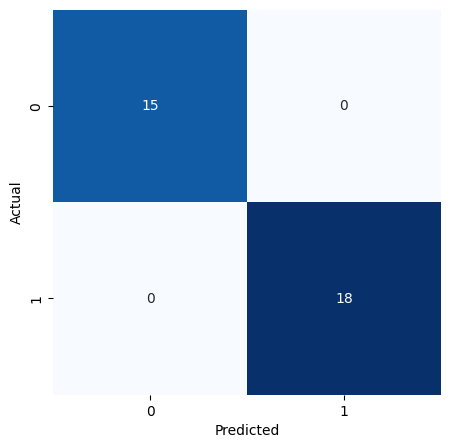

In [10]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=23)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with CatBoost

## Hyperparameters finetuning

### create the objective function

In [20]:
def my_cb(k1):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a CatBoostClassifier
    model = CatBoostClassifier(verbose=False)

    # Train the classifier
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [21]:
pbounds = {
    'k1': (5, 30),
    }


optimizer = BayesianOptimization(
    f=my_cb,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |
-------------------------------------
| 1         | 1.0       | 15.43     |
| 2         | 1.0       | 23.01     |
| 3         | 1.0       | 5.003     |
| 4         | 1.0       | 12.56     |
| 5         | 1.0       | 8.669     |
| 6         | 1.0       | 7.308     |
| 7         | 1.0       | 9.657     |
| 8         | 1.0       | 13.64     |
| 9         | 1.0       | 14.92     |
| 10        | 1.0       | 18.47     |
| 11        | 1.0       | 30.0      |
| 12        | 1.0       | 30.0      |
| 13        | 1.0       | 30.0      |
| 14        | 1.0       | 30.0      |
| 15        | 1.0       | 5.0       |
| 16        | 1.0       | 29.99     |
| 17        | 1.0       | 5.001     |
| 18        | 1.0       | 30.0      |
| 19        | 1.0       | 5.004     |
| 20        | 1.0       | 29.99     |
Bayes optimization takes 25.82 seconds to tune
{'target': 1.0, 'params': {'k1': 15.42555011756435}}


## Perform Binary classification

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


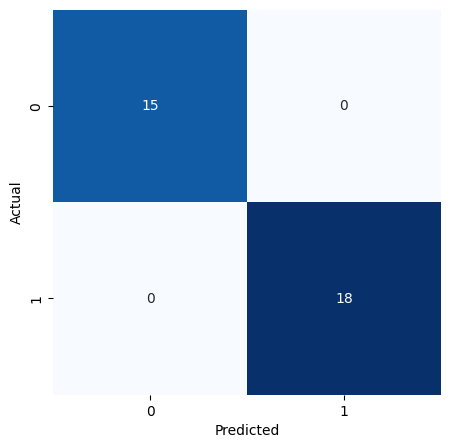

In [23]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a CatBoostClassifier
model = CatBoostClassifier(verbose=False)

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification with AdaBoost

## Hyperparameters finetuning

### create the objective function

In [26]:
def my_ab(k1, n):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)

    # split data into train and test sets

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Create a CatBoostClassifier
    model = AdaBoost(n_estimators=int(n))

    # Train the classifier
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [27]:
pbounds = {
    'k1': (5, 30),
    'n': (10, 200)
    }


optimizer = BayesianOptimization(
    f=my_ab,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |     n     |
-------------------------------------------------
| 1         | 1.0       | 15.43     | 146.9     |
| 2         | 0.9696    | 5.003     | 67.44     |
| 3         | 1.0       | 8.669     | 27.54     |
| 4         | 1.0       | 9.657     | 75.66     |
| 5         | 1.0       | 14.92     | 112.4     |
| 6         | 1.0       | 15.48     | 140.2     |
| 7         | 1.0       | 10.11     | 176.8     |
| 8         | 0.9696    | 5.685     | 137.4     |
| 9         | 1.0       | 15.43     | 116.2     |
| 10        | 1.0       | 8.51      | 47.64     |
| 11        | 1.0       | 21.91     | 142.9     |
| 12        | 1.0       | 13.17     | 82.4      |
| 13        | 1.0       | 8.057     | 37.79     |
| 14        | 1.0       | 19.77     | 75.72     |
| 15        | 0.9696    | 17.77     | 41.62     |
| 16        | 0.9696    | 5.315     | 82.85     |
| 17        | 1.0       | 14.68     | 77.23     |
| 18        | 1.0       | 19.98     | 83.24     |


## Perform Binary classification

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


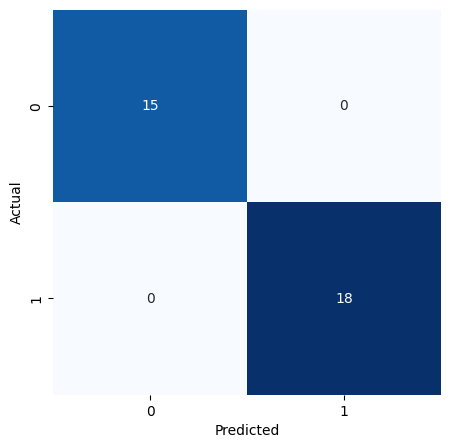

In [29]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Create a AdaBoostClassifier
model = AdaBoost(n_estimators=146)

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()